# Feature engineering with SHAP

## Load model and data

In [ ]:
import joblib
import shap
import pandas as pd
import numpy as np
import random
import os

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

plant_dir = os.environ.get("PLANT_DIR")
if not plant_dir:
    raise EnvironmentError("PLANT_DIR environment variable is not set")

classifier_path = os.path.join(plant_dir, \
                                "experimental_setup",\
                                "models", \
                                "models_genic_m_esculenta_PCA", \
                                "model_undersampling_XGBoost_50.pkl")

XGB = joblib.load(classifier_path)
model = XGB["model"]
scaler = XGB["scaler"]
le = XGB["label_encoder"]
feature_names = XGB["feature_names"]

/home/bruna.simoes/test_model/testing_ML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from sklearn.model_selection import train_test_split

def import_data_everything(dataset="dataset_genemark_1500_50.csv"):
    data = pd.read_csv(dataset)
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    data = data.drop(columns=["species"])
    data = data.dropna()

    return data

def import_split_scale_data(dataset, le, scaler, feature_names):

    dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

    features = dataset[feature_names]
    dataset["_features_tuple"] = features.apply(lambda row: tuple(row), axis=1)
    dataset = dataset.drop_duplicates(subset="_features_tuple", keep="first")
    dataset = dataset.drop(columns=["_features_tuple"])
    
    dataset["label"] = le.fit_transform(dataset["label"])

    X = dataset[feature_names]
    y = dataset.loc[:,'label'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.naive_bayes import label_binarize
from imblearn.under_sampling import RandomUnderSampler

data = import_data_everything()
X_train, X_test, y_train, y_test = import_split_scale_data(data, le, scaler, feature_names)
y_test_bin = label_binarize(y_test, classes=list(range(len(le.classes_))))

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

rs = RandomUnderSampler(random_state=42)
X_train, y_train = rs.fit_resample(X_train, y_train)

In [ ]:
explainer = shap.Explainer(model)

X_test_df = pd.DataFrame(X_test, columns=feature_names)
shap_values = explainer(X_test_df)

shap.summary_plot(shap_values, X_test_df, feature_names=feature_names)

In [ ]:
import matplotlib.pyplot as plt

fig = shap.plots.bar(shap_values, show=False)
plt.tight_layout()
plt.savefig("shap_values_genemark_bar.png", dpi=700)
plt.close()

fig = shap.plots.beeswarm(shap_values, show=False)
plt.tight_layout()
plt.savefig("shap_values_genemark_beeswarm.png", dpi=700)
plt.close()

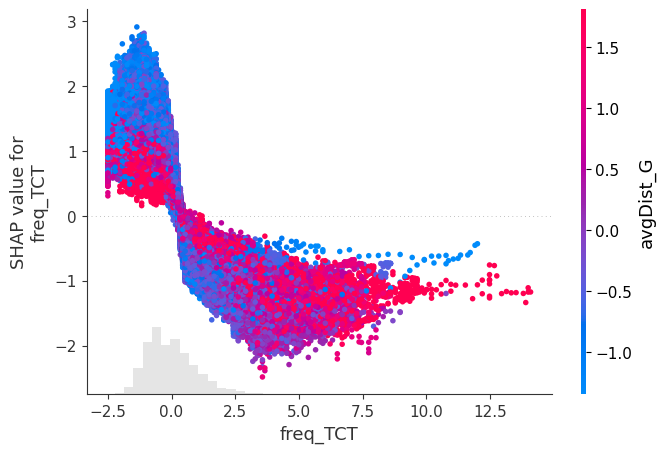

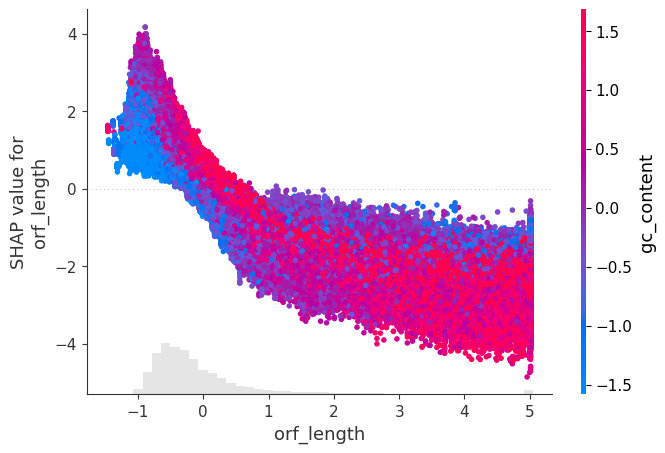

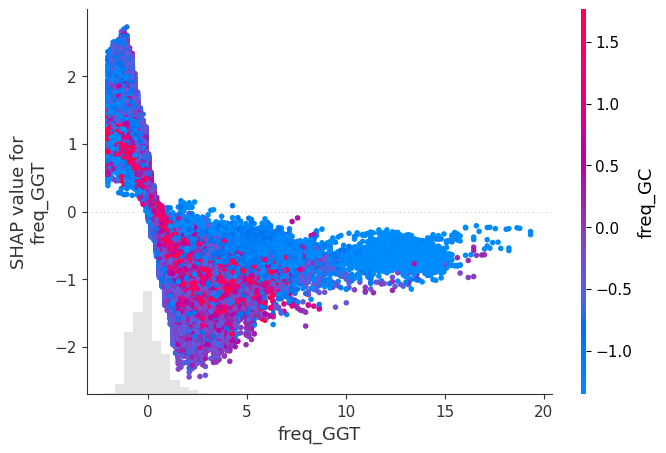

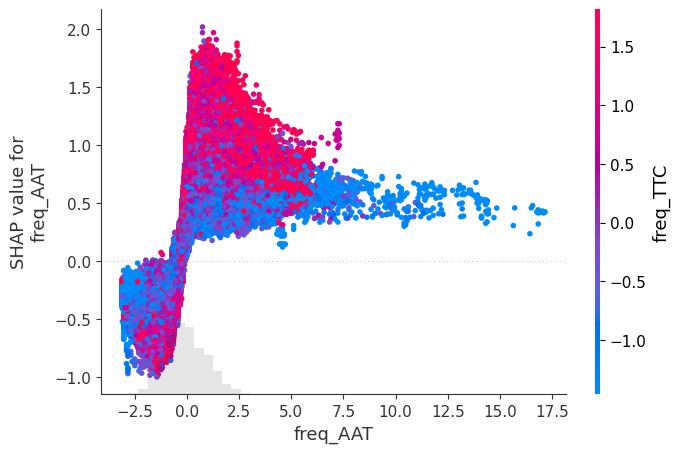

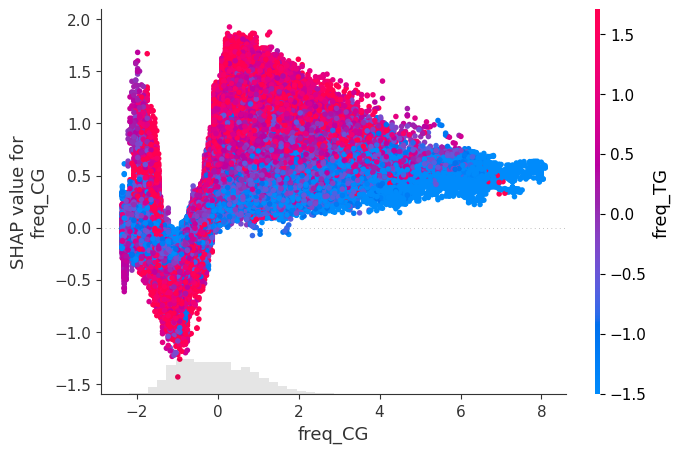

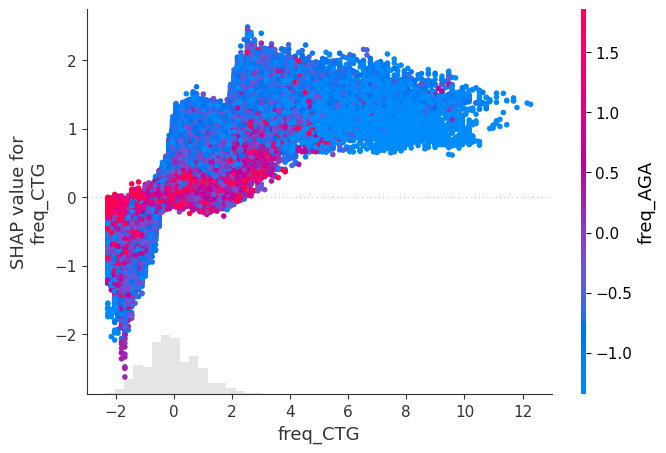

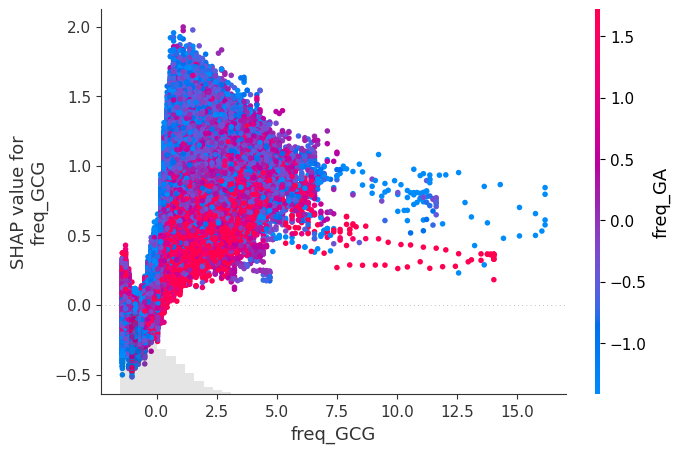

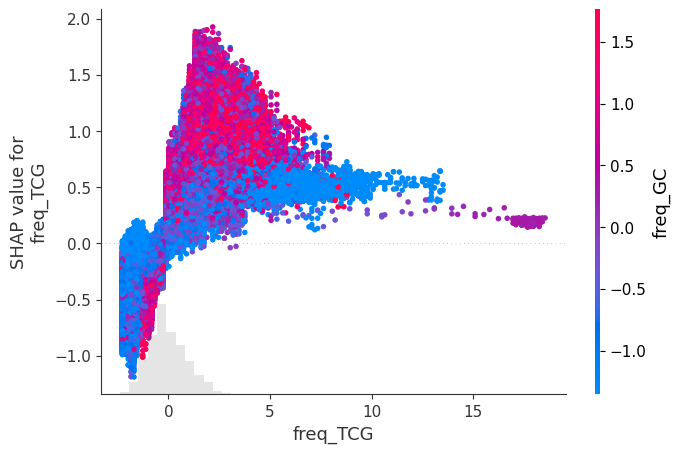

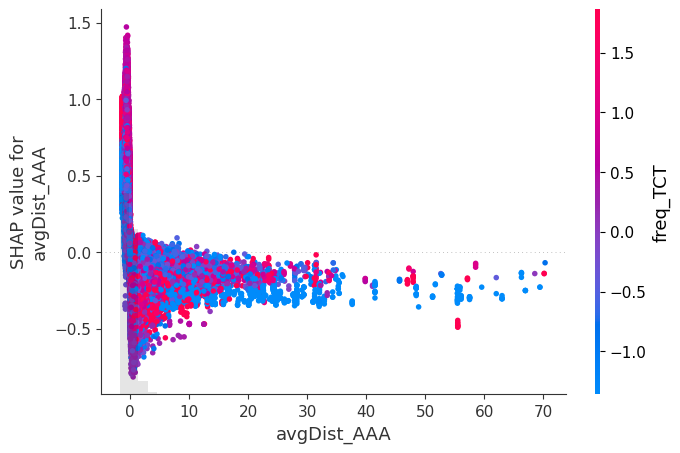

In [ ]:
top_features = ["freq_TCT", "orf_length", "freq_GGT", "freq_AAT", "freq_CG", "freq_CTG", "freq_GCG", "freq_TCG", "avgDist_AAA"]

for feature in top_features:
    fig = shap.plots.scatter(shap_values[:, feature], color=shap_values, show=False)
    plt.tight_layout()
    plt.savefig(f"shap_values_genemark_feature_{feature}.png", dpi=700)
    plt.close()

In [ ]:
from sklearn.metrics import average_precision_score, classification_report, roc_auc_score


y_pred = model.predict(X_test)
y_pred_bin = label_binarize(y_pred, classes=list(range(len(le.classes_))))

report = classification_report(y_test, y_pred, output_dict=True)
auc_roc = roc_auc_score(y_test_bin, y_pred_bin, average="macro", multi_class="ovr")
auc_pr = average_precision_score(y_test_bin, y_pred_bin, average="macro")

result = {
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"],
        "AUC-ROC": auc_roc,
        "AUC-PRC": auc_pr
    }

results = []
results.append(result)

print(pd.DataFrame(results))

misclassified_indices = np.where(y_pred != y_test)[0]

index_0 = misclassified_indices[0]
index_3 = misclassified_indices[3]
index_9 = misclassified_indices[9]

shap.plots.waterfall(shap_values[index_0], max_display=15)
shap.plots.waterfall(shap_values[index_3], max_display=15)
shap.plots.waterfall(shap_values[index_9], max_display=15)